In [25]:
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from keras import layers, models
import pathlib
import natsort
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [27]:
class readDataset:
    #Initialize the class with a dataset path.
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path


    #Create a method to read and sort file paths for images and masks using the 'natsort' library.
    def readPathes(self,):
      self.images = natsort.natsorted(list(pathlib.Path(os.path.join(self.dataset_path,'images')).glob('*.jpg')))
      self.masks = natsort.natsorted(list(pathlib.Path(os.path.join(self.dataset_path,'masks')).glob('*.*')))


    # Create a method to read images given a list of file paths and data type ('m' for masks, else for images).
    def readImages(self, data, typeData):
        #Initialize an empty list to store processed images.
        images = []
        #Loop through each file path in the given data.
        for img in data:
            #If the data type is a mask ('m'), read the image in grayscale.
            if typeData == 'm':
              img = cv2.imread(str(img), 0)
            #If the data type is an image, read and convert it to RGB format.
            else:
              img = cv2.imread(str(img),)
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #Normalize pixel values to the range [0, 1].
            img = img/255
            #Resize the image to a fixed size (64x64).
            img = cv2.resize(img, (64, 64))
            #If the data type is a mask, convert it to binary values (0 or 1).
            if typeData == 'm':
                img = np.where(img > 0, 1, 0)
            #Append the processed image to the list.
            images.append(img)
        return np.array(images)


    def dataAugmentation(self, images, masks, labels):
        #Initialize empty lists to store augmented data.
        imagesupdate = []
        masksupdate = []
        labelsupdate = []
        #Loop through each image, mask, and label.
        for image, mask, label in zip(images, masks, labels):
          #Apply three types of augmentation: no augmentation, horizontal flip, and vertical flip.
          for aug in range(3):
            imageup = image
            maskup = mask
            #original
            if aug == 0:
              imageup = image
              maskup = mask
            #horizontal flip
            elif aug == 1:
              imageup = tf.image.flip_left_right(imageup)
              maskup = tf.image.flip_left_right(maskup)
            #vertical flip
            else:
              imageup = tf.image.flip_up_down(imageup)
              maskup = tf.image.flip_up_down(maskup)
            #Append the augmented data to the respective lists.
            imagesupdate.append(imageup)
            masksupdate.append(maskup)
            labelsupdate.append(label)
        return np.array(imagesupdate), np.array(masksupdate), np.array(labelsupdate)

In [29]:
datasetObject = readDataset("C:\\Users\\iampi\\OneDrive\\Desktop\\SkinScanAI\\data")
datasetObject.readPathes()

In [30]:
len(datasetObject.images), len(datasetObject.masks)

(10015, 10015)

In [31]:
images = datasetObject.readImages(datasetObject.images, 'i')
masks = datasetObject.readImages(datasetObject.masks, 'm')
images.shape, masks.shape

((10015, 64, 64, 3), (10015, 64, 64))

In [32]:
labels = pd.read_csv('C:\\Users\\iampi\\OneDrive\\Desktop\\SkinScanAI\\data\\GroundTruth.csv')
labels.head()

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0

In [33]:
labels = labels.drop(['image'], axis = 1)
labels.head()

MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  1.0  0.0  0.0    0.0  0.0  0.0   0.0

In [34]:
labels = np.array(labels)
labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

Use data augmentation(no  augmentation,horizontal and vertical  == around 30k images and masks) to generate new samples from the training images

In [35]:
images, masks, labels = datasetObject.dataAugmentation(images, np.reshape(masks, (masks.shape[0], 64, 64, 1)), labels)
images.shape, masks.shape, labels.shape

((30045, 64, 64, 3), (30045, 64, 64, 1), (30045, 7))

In [36]:
def show_sample(images, masks, labels_):
    #Convert one-hot encoded labels to categorical labels.
    labels = np.argmax(labels_, axis = 1)
    #Create a figure for the plot with a specified size.
    plt.figure(figsize = (12, 12))
    for i in range(64):
        #Specify the subplot position in an 8x8 grid.
        plt.subplot(8, 8, (i + 1))
        #Display the image with a transparency overlay of the mask.
        plt.imshow(images[i],)
        #Overlay the mask on top of the image with a transparency of 0.2
        plt.imshow(masks[i], alpha = 0.2)
        # Set the title of the subplot to the categorical label.
        plt.title(labels[i])
    plt.legend()

Samples from the dataset, the images appear after applying several data augmentation methodologies to medical images, with the aim of making the neural network study many other features that help locate the skin lesion..

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


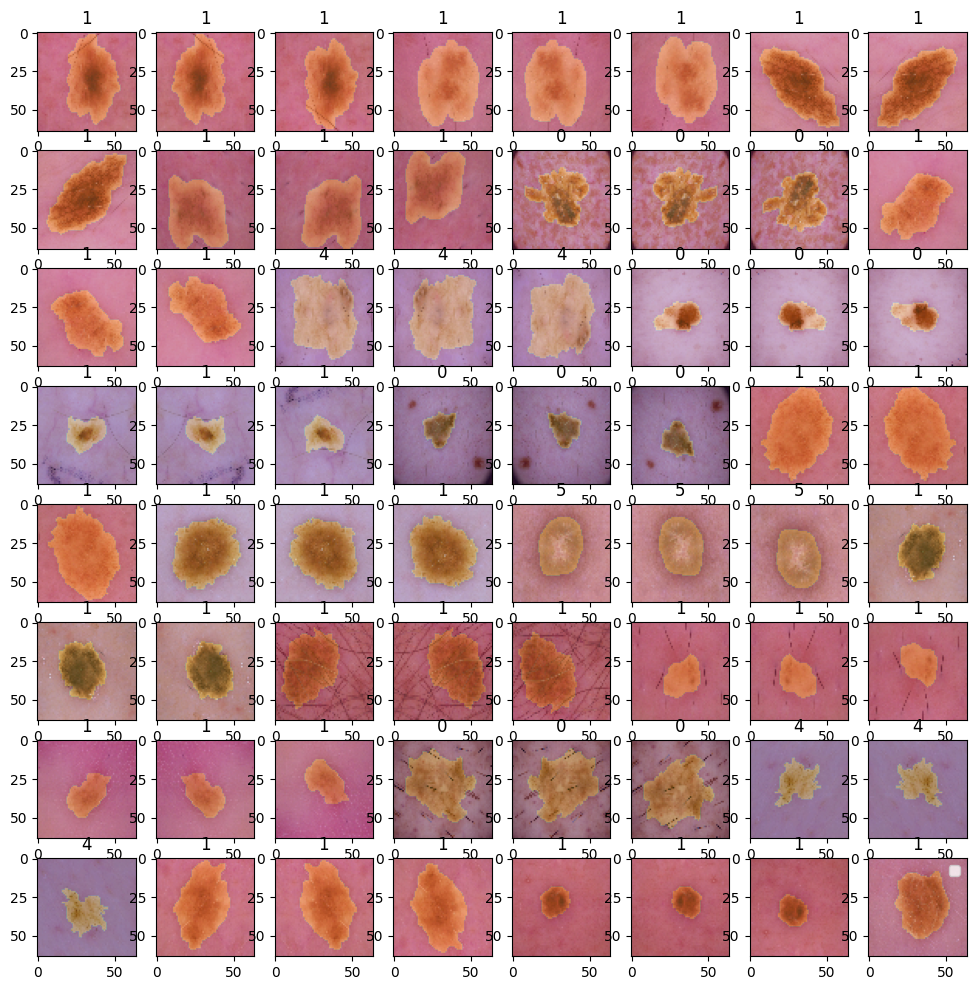

In [37]:
show_sample(images, masks, labels)

In [38]:
#Randomly shuffle the indices to create a random order for the dataset.
indexs = np.random.choice(range(masks.shape[0]), size = (masks.shape[0]), replace = False)
#Use the shuffled indices to rearrange the images, masks, and labels in the same order.
images = images[indexs]
masks = masks[indexs]
labels = labels[indexs]

In [39]:
indexs

array([15825,  6086, 10385, ...,  6092, 26222, 20159])

In [40]:
#Define the size of the validation set and test set.
validSize = 3500
testSize = 1000
#Select the first 3500 images, masks, and labels for the validation set.
validImages = images[:validSize]
validMasks = masks[:validSize]
validLabels = labels[:validSize]
#Select images, masks, and labels for the test set.
testImages = images[validSize: validSize + testSize]
testMasks = masks[validSize: validSize + testSize]
testLabels = labels[validSize:validSize + testSize]
#Select the remaining images, masks, and labels for the training set.
trainImages = images[validSize + testSize:]
trainMasks = masks[validSize + testSize:]
trainLabels = labels[validSize + testSize:]

In [41]:
trainImages.shape, validImages.shape, trainMasks.shape, validMasks.shape, testImages.shape, testLabels.shape, testMasks.shape

((25545, 64, 64, 3),
 (3500, 64, 64, 3),
 (25545, 64, 64, 1),
 (3500, 64, 64, 1),
 (1000, 64, 64, 3),
 (1000, 7),
 (1000, 64, 64, 1))

In [42]:
np.min(trainImages), np.max(trainImages), np.min(validImages), np.max(validImages)

(0.0, 1.0, 0.0, 1.0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


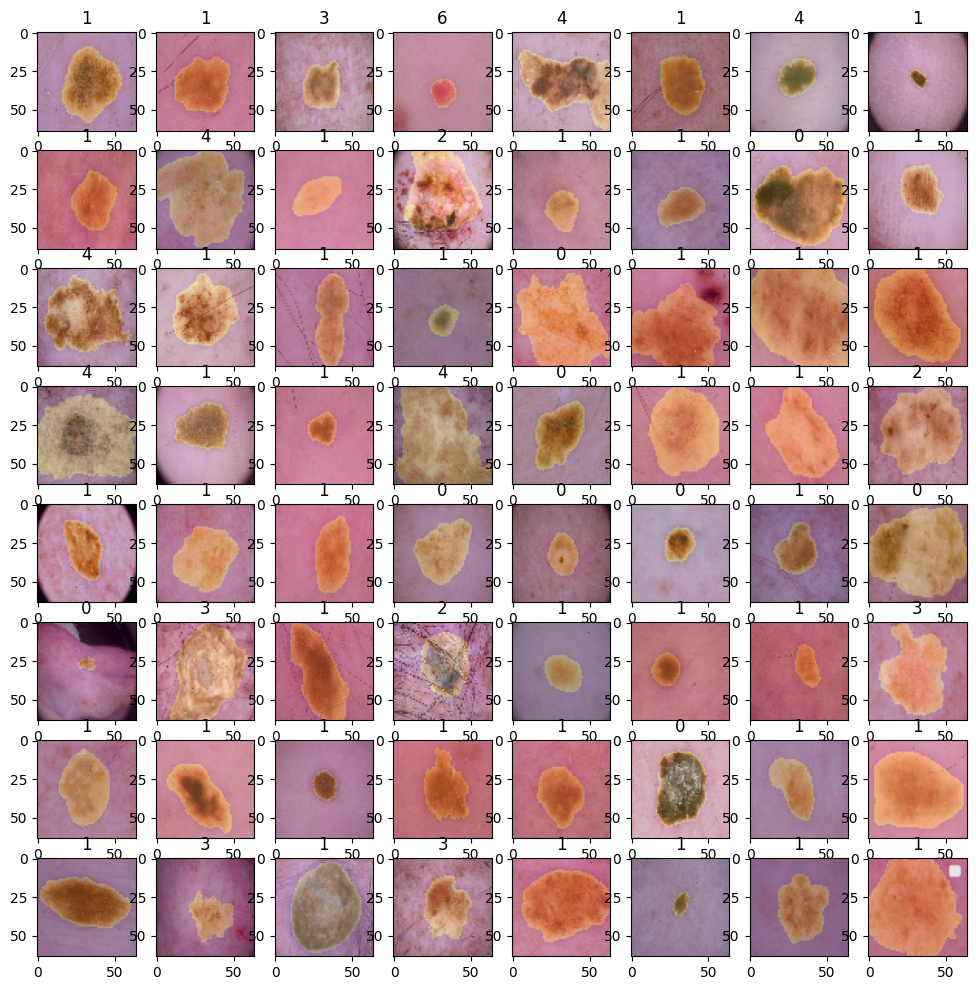

In [43]:
show_sample(validImages, validMasks, validLabels)

The proposed neural network architecture

* **filter**: Filters are small matrices that we engage across      dataset with the help of a sliding window which convolves image 
* **kernel_size**: defines the size of the convolutional kernel
* **padding**: Adding extra pixels(0's) to input data before applying convolution to control the size of output
* **strides**: determine the step size of the convolutional kernel as it moves across the input
* **kernel_regularizer**: Adds the squared values of the weights to the loss function,Discourages large weights and helps prevent overfitting,Encourages a smooth weight distribution.
* **bias_regularizer**: same as kernel_regularizer but for biases
* **BatchNormalization**: normalizes layer inputs, aiding stable training and faster convergence. It scales and shifts values, improving overall network performance and is commonly used in CNNs.
* **Activation function**: like relu introduces non-linearity to network to tensor x

In [44]:
#Define a convolutional block function with parameters for customization.
def convolution(input, filter, strides, padding, kernel_size, activation, layernorm):
    x = input
    x = layers.Conv2D(filter, kernel_size = kernel_size, padding = padding,
                     strides = strides,
                     kernel_regularizer = tf.keras.regularizers.L2(0.001),
                     bias_regularizer = tf.keras.regularizers.L2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(filter, kernel_size = kernel_size, padding = padding,
                     strides = strides,
                     kernel_regularizer = tf.keras.regularizers.L2(0.001),
                     bias_regularizer = tf.keras.regularizers.L2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(filter, kernel_size = kernel_size, padding = padding,
                     strides = strides,
                     kernel_regularizer = tf.keras.regularizers.L2(0.001),
                     bias_regularizer = tf.keras.regularizers.L2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x

**AveragePooling2D**:   is applied after a convolutional layer, downsampling the spatial dimensions of the input by taking the average within each 2x2 region.

In [45]:
def encoder(input, filter, strides, padding, kernel_size, activation, layernorm):
    x = input
    x = convolution(x, filter, strides, padding, kernel_size, activation, layernorm)
    downsample = layers.AveragePooling2D()(x)
    return x, downsample

In [46]:
def decoder(input, skip, otherSkips, filter, strides, padding, kernel_size, activation, layernorm):
    x = input
    # Upsample the input using Conv2DTranspose.
    x = layers.Conv2DTranspose(filter, kernel_size = kernel_size, padding = padding,
                              strides = 2, )(x)
    #Apply activation function to the upsampled tensor.
    x = layers.Activation(activation)(x)
    if otherSkips != None:
        z = None
        s = 2
        list_skips = []
        #Loop through otherSkips and apply Conv2D to each.
        for skip_ in otherSkips:
            #Apply normalization to each skip.
            z = layers.BatchNormalization()(layers.Conv2D(filter, kernel_size = 1,strides = s, padding = 'same',
                                                          activation = activation,
                                                          kernel_regularizer = tf.keras.regularizers.L2(0.001),
                                                          bias_regularizer = tf.keras.regularizers.L2(0.001))(skip_))
            list_skips.append(z)
            s = s*2
    if otherSkips != None:
    #Calculate the average of the otherSkips.
     y = layers.average(list_skips)
     #Calculate the average of the current skip and the upsampled x.
    x = layers.average([x, skip])
    if otherSkips != None:
    # Calculate the average of x, y, and the skip.
     x = layers.average([x, y])
    x = convolution(x, filter, strides, padding, kernel_size, activation, layernorm)
    return x

**Cross-Entropy**
Loss function that measures the performance of a classification model whose output is a probability distribution over classes. The cross-entropy loss increases as the predicted probability diverges from the actual label.
In the binary classification case, where there are only two classes (0 and 1), the formula for binary cross entropy is:
* L(y,y^)=−1/N∑ i=1,N[yi(log(y^i))+(1−yi)log(1−y^i)]
* yi is the true label (either 0 or 1) for the i-th instance
* y^i is the predicted probability that the instance belongs to class 1.

In [47]:
input = layers.Input(shape = (64, 64, 3))
filter = 64
kernel = 3
# Apply encoder function for downsampling and skip connections
skip1, downsample1 = encoder(input, filter, strides = 1, padding = 'same', kernel_size = kernel, activation = 'relu', layernorm = False)
skip2, downsample2 = encoder(downsample1, filter*2, strides = 1, padding = 'same', kernel_size = kernel, activation = 'relu', layernorm = False)
skip3, downsample3 = encoder(downsample2, filter*4, strides = 1, padding = 'same', kernel_size = kernel, activation = 'relu', layernorm = False)
skip4, downsample4 = encoder(downsample3, filter*8, strides = 1, padding = 'same', kernel_size = kernel, activation = 'relu', layernorm = False)
# Flatten downsampled features
features_map = layers.Flatten()(downsample4)
# Apply dropout regularization to flattened features
x = layers.Dropout(0.7)(features_map)
# Create a dense layer for the latent space
x = layers.Dense(32, name = 'latent_space', kernel_regularizer = tf.keras.regularizers.L2(0.001),
                 bias_regularizer = tf.keras.regularizers.L2(0.001))(x)
# Apply dropout regularization to the latent space features for label prediction
xlabels = layers.Dropout(0.6)(x)
# Create dense layer for label prediction with ReLU activation
xlabels = layers.Dense(8, activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(0.001),
                       bias_regularizer = tf.keras.regularizers.L2(0.001))(xlabels)
# Apply dropout regularization to label prediction features
xlabels = layers.Dropout(0.4)(xlabels)
# Create final dense layer for label prediction with softmax activation
xlabels = layers.Dense(7,activation = 'softmax', name = 'label')(xlabels)
# Create dense layer before reshaping for the decoder
x = layers.Dense(4*4*512, kernel_regularizer = tf.keras.regularizers.L2(0.001),
                 bias_regularizer = tf.keras.regularizers.L2(0.001))(x)
x = layers.Reshape((4, 4, 512))(x)
# Apply decoder function for upsampling with skip connections
upsample2 = decoder(x, skip4, [skip3, skip2, skip1], filter*8, 1,'same', kernel, 'relu', True)
upsample3 = decoder(upsample2, skip3, [skip2, skip1], filter*4, 1,'same', kernel, 'relu', True)
upsample4 = decoder(upsample3, skip2, None, filter*2, 1,'same', kernel, 'relu', True)
# Combine upsampled features with features from a 1x1 convolution on the skip connection
upsample4 = layers.average([
    upsample4,
    layers.BatchNormalization()(layers.Conv2DTranspose(filter*2, kernel_size = 1, padding = 'same', strides = 4,
                                                       activation = 'relu')(upsample2)),
])
# Apply convolutional operations using the helper function
upsample4 = convolution(upsample4, filter*2, 1, 'same', kernel, 'relu', True)
# Apply final decoder stage for upsampling
upsample5 = decoder(upsample4, skip1, None, filter, 1,'same',kernel, 'relu', True)
# Combine upsampled features with features from 1x1 convolutions on skip connections at different scales
upsample5 = layers.average([
    upsample5,
    layers.BatchNormalization()(layers.Conv2DTranspose(filter, kernel_size = 1, padding = 'same', strides = 4,
                                                       activation = 'relu')(upsample3)),
    layers.BatchNormalization()(layers.Conv2DTranspose(filter, kernel_size = 1, padding = 'same', strides = 8,
                                                       activation = 'relu')(upsample2)),
])
# Apply convolutional operations using the helper function
upsample5 = convolution(upsample5, filter, 1, 'same', kernel, 'relu', True)
# Create output layer for the mask prediction
output = layers.Conv2D(1, kernel_size = kernel, padding = 'same', strides = 1,)(upsample5)
output = layers.Activation('sigmoid', name = 'mask')(output)
# Create the generator model with input and output layers
generator = models.Model(inputs = input, outputs = [output, xlabels])
# Compile the generator model with specified loss, optimizer, and metrics
generator.compile(loss = [tf.keras.losses.BinaryFocalCrossentropy(), 'categorical_crossentropy'],
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001,),
                  metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'), tf.keras.metrics.Precision(name = 'precision'),
                             tf.keras.metrics.Recall(name = 'recall'), ])
generator.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 64, 64, 64)           0         ['batch_normalization[0]

In [48]:
history = generator.fit(trainImages, [trainMasks, trainLabels], epochs = 120, batch_size = 16,
validation_data = (validImages, [validMasks, validLabels]),
callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, monitor = 'val_mask_loss',mode = 'min',restore_best_weights = True),])

Epoch 1/120


1597/1597 [==============================] - 4248s 3s/step - loss: 7.4986 - mask_loss: 0.0671 - label_loss: 1.5251 - mask_accuracy: 0.8957 - mask_precision: 0.8112 - mask_recall: 0.7956 - label_accuracy: 0.8856 - label_precision: 0.7325 - label_recall: 0.3137 - val_loss: 6.0900 - val_mask_loss: 0.0455 - val_label_loss: 1.0479 - val_mask_accuracy: 0.9339 - val_mask_precision: 0.9275 - val_mask_recall: 0.8207 - val_label_accuracy: 0.9083 - val_label_precision: 0.9517 - val_label_recall: 0.3771
Epoch 2/120
1597/1597 [==============================] - 2309s 1s/step - loss: 5.7978 - mask_loss: 0.0414 - label_loss: 1.2811 - mask_accuracy: 0.9392 - mask_precision: 0.9075 - mask_recall: 0.8607 - label_accuracy: 0.8992 - label_precision: 0.8251 - label_recall: 0.3733 - val_loss: 5.0787 - val_mask_loss: 0.0409 - val_label_loss: 0.9727 - val_mask_accuracy: 0.9389 - val_mask_precision: 0.9147 - val_mask_recall: 0.8545 - val_label_accuracy: 0.9149 - val_label_precision: 0.9322 - val_l

Prediction of lesion types

In [72]:
print(len(testImages))

1000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Predict masks and labels for test images
predicted_masks, predicted_labels = generator.predict(testImages)

# 'predicted_labels' contains the predicted lesion types
# Assuming 'predicted_labels' is one-hot encoded, you can get the predicted class index for each sample
predicted_classes = np.argmax(predicted_labels, axis=1)

# Display images along with actual and predicted labels in a multi-page format
num_images = len(testImages)
images_per_page = 100  
num_rows = 10  # Number of rows for subplots
num_cols = images_per_page // num_rows  # Calculate number of columns based on rows

num_pages = int(np.ceil(num_images / images_per_page))

for page in range(num_pages):
    plt.figure(figsize=(20, 15))
    
    start_idx = page * images_per_page
    end_idx = min((page + 1) * images_per_page, num_images)

    for i in range(start_idx, end_idx):
        plt.subplot(num_rows, num_cols, i % images_per_page + 1)
        
        # Ensure the image data is in the correct range (0-1 or 0-255)
        plt.imshow(testImages[i])  # Assuming testImages are in the correct range
        
        # Display actual label
        actual_label = np.argmax(testLabels[i])  # Assuming one-hot encoded labels
        plt.title(f'Actual: {actual_label}\nPredicted: {predicted_classes[i]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Accuracy and confusion matrix for predicting labels

In [67]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Calculate confusion matrix
conf_matrix = confusion_matrix(np.argmax(testLabels, axis=1), predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate accuracy
accuracy = accuracy_score(np.argmax(testLabels, axis=1), predicted_classes)
print("Accuracy:", accuracy)


Confusion Matrix:
[[ 50  75   0   0   1   0   0]
 [ 12 645   0   0   0   0   0]
 [  9  47   0   0   0   0   0]
 [  4  24   0   0   0   0   0]
 [  8  98   0   0   0   0   0]
 [  0  10   0   0   0   0   0]
 [ 10   7   0   0   0   0   0]]
Accuracy: 0.695


Performance Evaluation Measures:

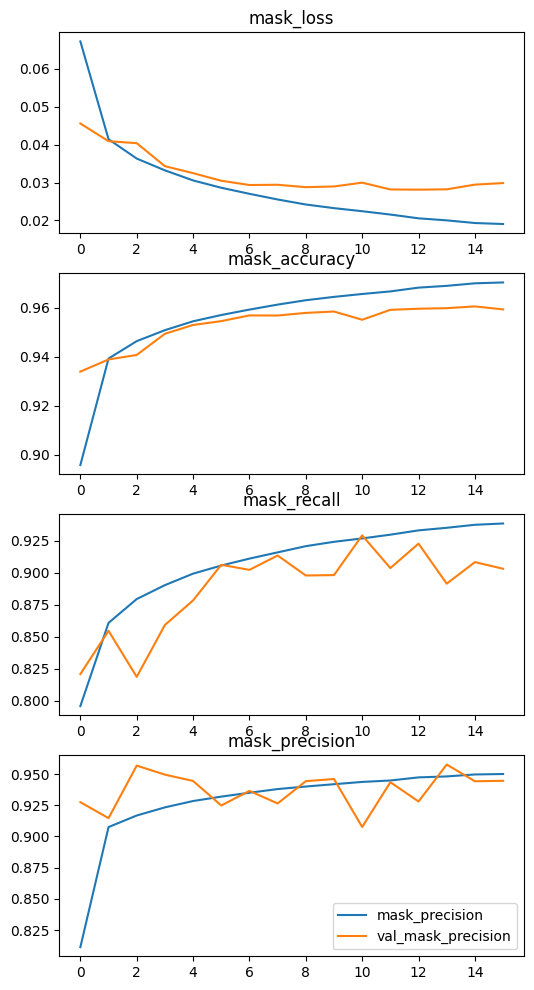

In [61]:
#Define the metrics to be visualized
metrics = ['mask_loss','mask_accuracy', 'mask_recall', 'mask_precision']
plt.figure(figsize = (6, 12))
for i in range(4):
    # Create a subplot with 4 rows and 1 column, and select the current subplot (indexed by i + 1)
    plt.subplot(4, 1, (i + 1))
    # Plot the training values of the selected metric
    plt.plot(history.history['{}'.format(metrics[i])], label = '{}'.format(metrics[i]))
    #Plot the validation values of the selected metric
    plt.plot(history.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))
plt.legend()

In [62]:
generator.save('C:/Users/iampi/OneDrive/Desktop/SkinScanAI/generator.h5')

c:\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Evaluate the performance of the model on the training data

In [63]:
generator.evaluate(trainImages, [trainMasks, trainLabels])

799/799 [==============================] - 440s 550ms/step - loss: 3.0225 - mask_loss: 0.0196 - label_loss: 0.6963 - mask_accuracy: 0.9703 - mask_precision: 0.9422 - mask_recall: 0.9473 - label_accuracy: 0.9371 - label_precision: 0.9271 - label_recall: 0.6076


[3.0224545001983643,
 0.019571879878640175,
 0.696342945098877,
 0.970320999622345,
 0.9421573281288147,
 0.9473294615745544,
 0.9371249675750732,
 0.9271293878555298,
 0.6076335906982422]

Evaluate model performance on validation data

In [64]:
generator.evaluate(validImages, [validMasks, validLabels])

110/110 [==============================] - 61s 556ms/step - loss: 3.0865 - mask_loss: 0.0281 - label_loss: 0.7518 - mask_accuracy: 0.9596 - mask_precision: 0.9281 - mask_recall: 0.9227 - label_accuracy: 0.9331 - label_precision: 0.9105 - label_recall: 0.5900


[3.086498975753784,
 0.028117164969444275,
 0.7518416047096252,
 0.9595885872840881,
 0.9280927777290344,
 0.9226922988891602,
 0.9331428408622742,
 0.9104938507080078,
 0.5899999737739563]

Evaluate model performance on test data

In [65]:
generator.evaluate(testImages, [testMasks, testLabels])

32/32 [==============================] - 17s 517ms/step - loss: 3.1278 - mask_loss: 0.0278 - label_loss: 0.7935 - mask_accuracy: 0.9596 - mask_precision: 0.9301 - mask_recall: 0.9246 - label_accuracy: 0.9320 - label_precision: 0.8958 - label_recall: 0.5930


[3.12781023979187,
 0.027803046628832817,
 0.79346764087677,
 0.959637463092804,
 0.9300879240036011,
 0.9246482849121094,
 0.9319999814033508,
 0.8957703709602356,
 0.5929999947547913]

In [68]:
class metrics:

  def __init__(self, images, masks):
    self.images = images
    self.masks = masks


  # Method to make predictions using the generator
  def predict(self,):
    # Predict masks using the generator
    masks_pred, _ = generator.predict(self.images)
    # Convert predicted masks to binary (0 or 1) using a threshold of 0.5
    masks_pred = (masks_pred >= 0.5).astype('int')
    return masks_pred


  # Method to flatten the predicted masks and actual masks
  def flatten(self, pred):
    # Flatten the predicted masks
    pred = layers.Flatten()(pred)
    # Reshape the flattened predicted masks to a 1D array
    pred  = np.reshape(pred, -1)
    # Flatten the actual masks
    actual = layers.Flatten()(self.masks)
    # Reshape the flattened actual masks to a 1D array
    actual  = np.reshape(actual, -1)
    return actual, pred


  # Method to print the classification report  
  def classification_report(self, actual, pred):
    print(classification_report(actual, pred))


  # Method to calculate and return additional metrics (accuracy, precision, recall, dice score)  
  def othersMetrics(self, actual, pred):
    # Calculate confusion matrix metrics
    tn, fp, fn, tp = confusion_matrix(actual, pred).ravel()
    # Create a DataFrame with additional metrics
    m = pd.DataFrame([
    accuracy_score(actual, pred)*100,
    precision_score(actual, pred)*100,
    recall_score(actual, pred)*100,
    ((2*tp)/(2*tp + fp + fn))*100
    ], index = ['accuracy score', 'precision score', 'recall score', 'dice score'],
      columns = ['Metrics For Validation Data'])
    return m

Evaluate model performance on test data

In [69]:
metTest = metrics(testImages, testMasks)
pred = metTest.predict()
actual, pred = metTest.flatten(pred)
metTest.classification_report(actual, pred)

32/32 [==============================] - 16s 485ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97   2954686
           1       0.93      0.92      0.93   1141314

    accuracy                           0.96   4096000
   macro avg       0.95      0.95      0.95   4096000
weighted avg       0.96      0.96      0.96   4096000



In [70]:
metTest.othersMetrics(actual, pred).head()

Metrics For Validation Data
accuracy score                     95.963745
precision score                    93.008790
recall score                       92.464826
dice score                         92.736010

Evaluate model performance on validation data

In [71]:
metValid = metrics(validImages, validMasks)
pred = metValid.predict()
actual, pred = metValid.flatten(pred)
metValid.classification_report(actual, pred)

110/110 [==============================] - 60s 542ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97  10442508
           1       0.93      0.92      0.93   3893492

    accuracy                           0.96  14336000
   macro avg       0.95      0.95      0.95  14336000
weighted avg       0.96      0.96      0.96  14336000



In [73]:
metValid.othersMetrics(actual, pred).head()

Metrics For Validation Data
accuracy score                     95.958859
precision score                    92.809279
recall score                       92.269228
dice score                         92.538466

In [74]:
def segmentation(data, m):
    masks_pred, _ = m.predict(data)
    masks_pred = np.array(masks_pred)
    masks_pred = (masks_pred >= 0.5).astype('int32')
    return masks_pred

In [75]:
def draw(images, masks, y_pred, ran):
  plt.figure(figsize = (12, 50))
  index = -1
  n = np.random.randint(y_pred.shape[0])
  for i in range(ran):
    plt.subplot(20, 6, (i + 1))
    if index == -1:
      plt.imshow(images[n],)
      plt.title('Image')
      index = 0
    elif index == 0:
      plt.imshow(images[n],)
      plt.imshow(masks[n], alpha = 0.5)
      plt.title('Original Mask')
      index = 1
    elif index == 1:
      plt.imshow(images[n],)
      plt.imshow(np.reshape(y_pred[n], (64, 64)), alpha = 0.5)
      plt.title('Predict Mask')
      index = -1
      n = np.random.randint(y_pred.shape[0])
  plt.legend()

In [76]:
masks_pred = segmentation(testImages, generator)
masks_pred.shape

32/32 [==============================] - 16s 498ms/step


(1000, 64, 64, 1)

**Visual samples of automatically locating skin lesion.**

A visual demonstration of the model's ability to predict the location of a skin lesion and determine its extent, on test Data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


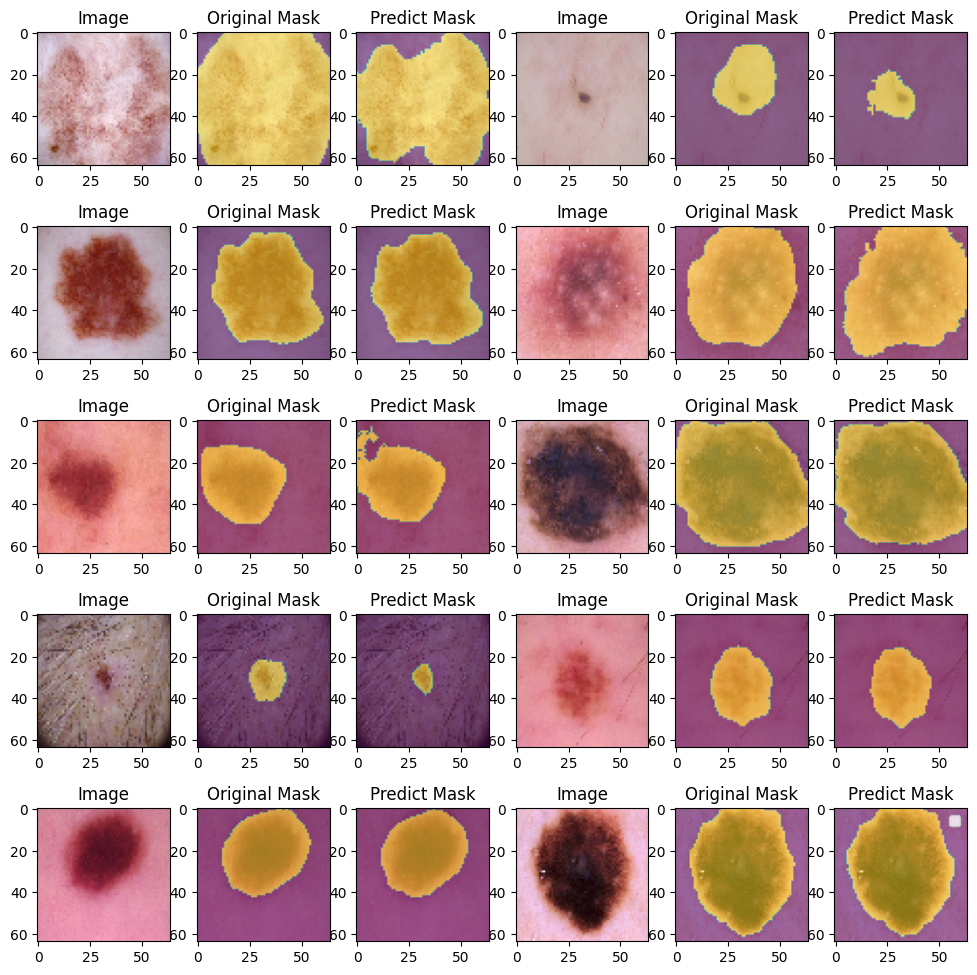

In [77]:
draw(testImages, testMasks, masks_pred, 30)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


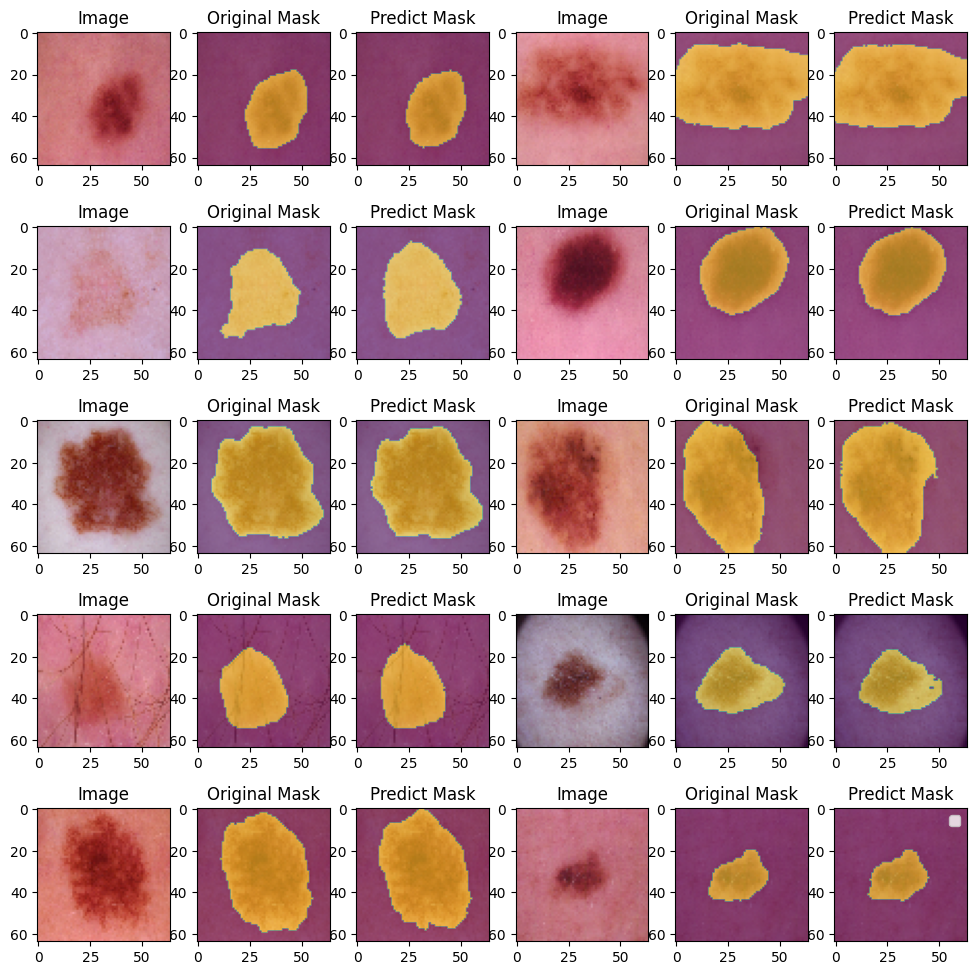

In [78]:
draw(testImages, testMasks, masks_pred, 30)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


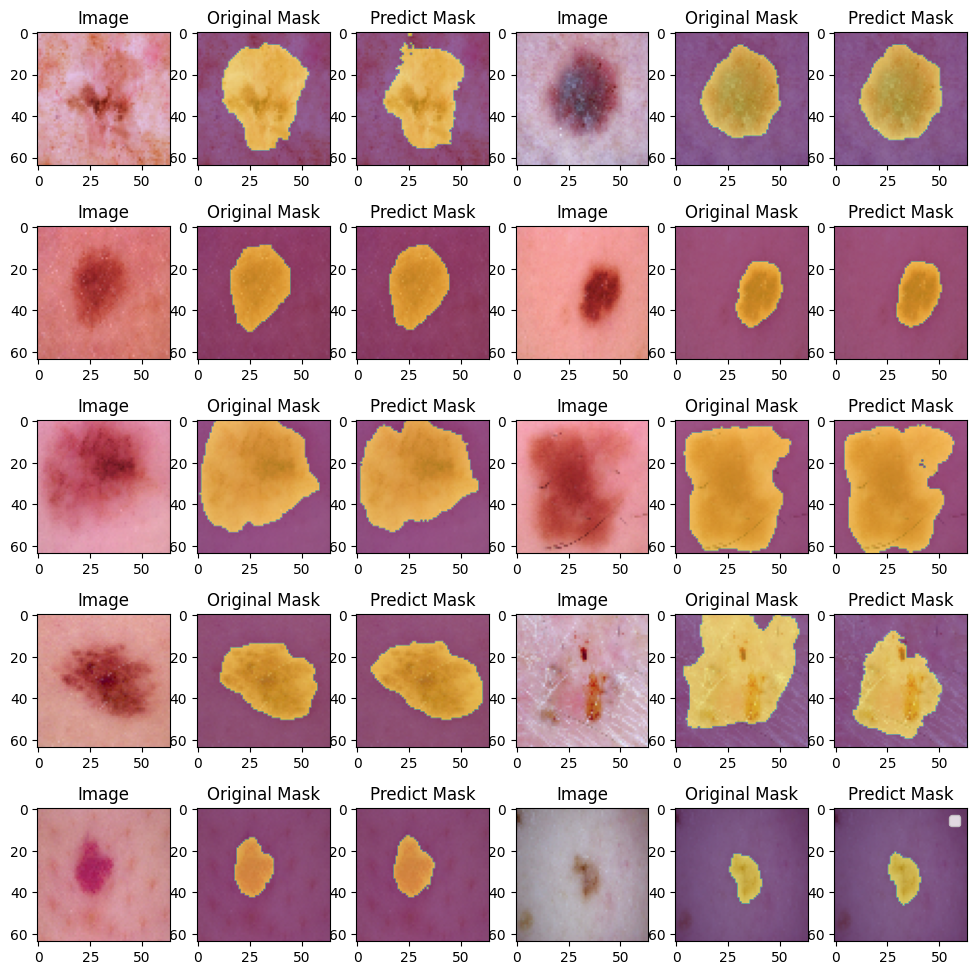

In [79]:
draw(testImages, testMasks, masks_pred, 30)

A visual demonstration of the model's ability to predict the location of a skin lesion and determine its extent, on validation Data

In [80]:
masks_pred = segmentation(validImages, generator)
masks_pred.shape

110/110 [==============================] - 59s 534ms/step


(3500, 64, 64, 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


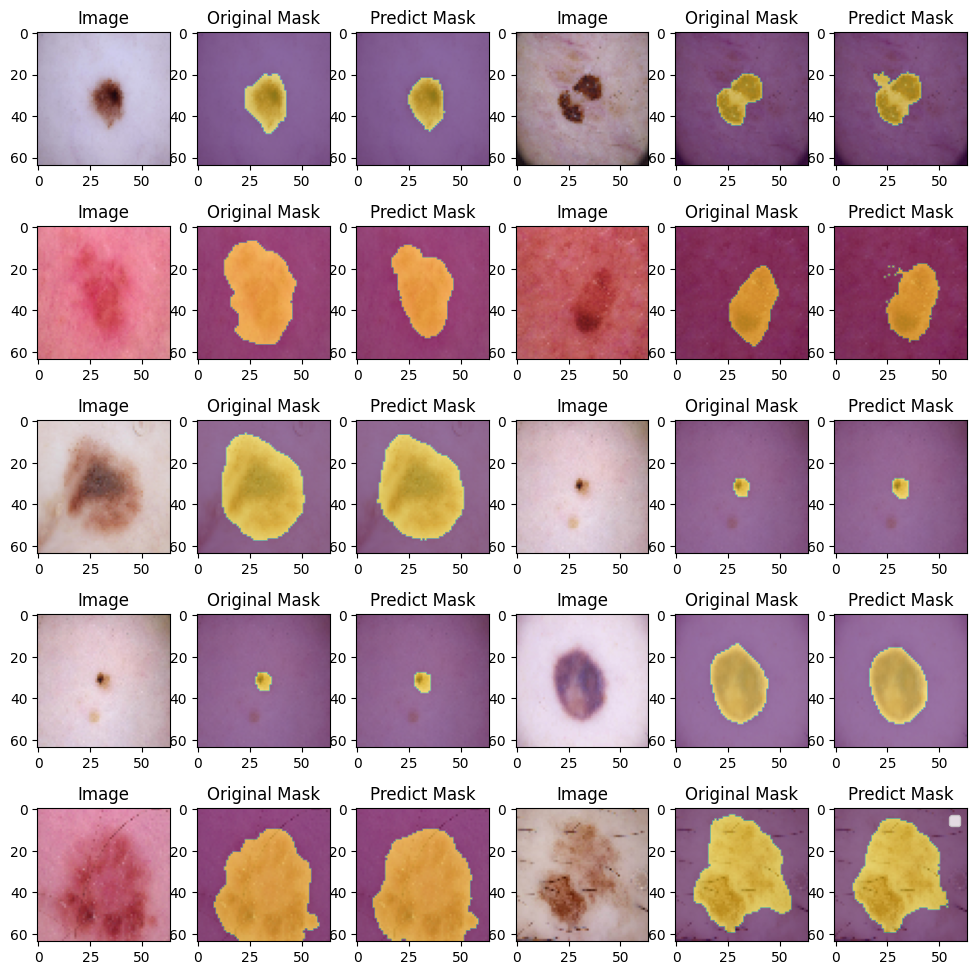

In [81]:
draw(validImages, validMasks, masks_pred, 30)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


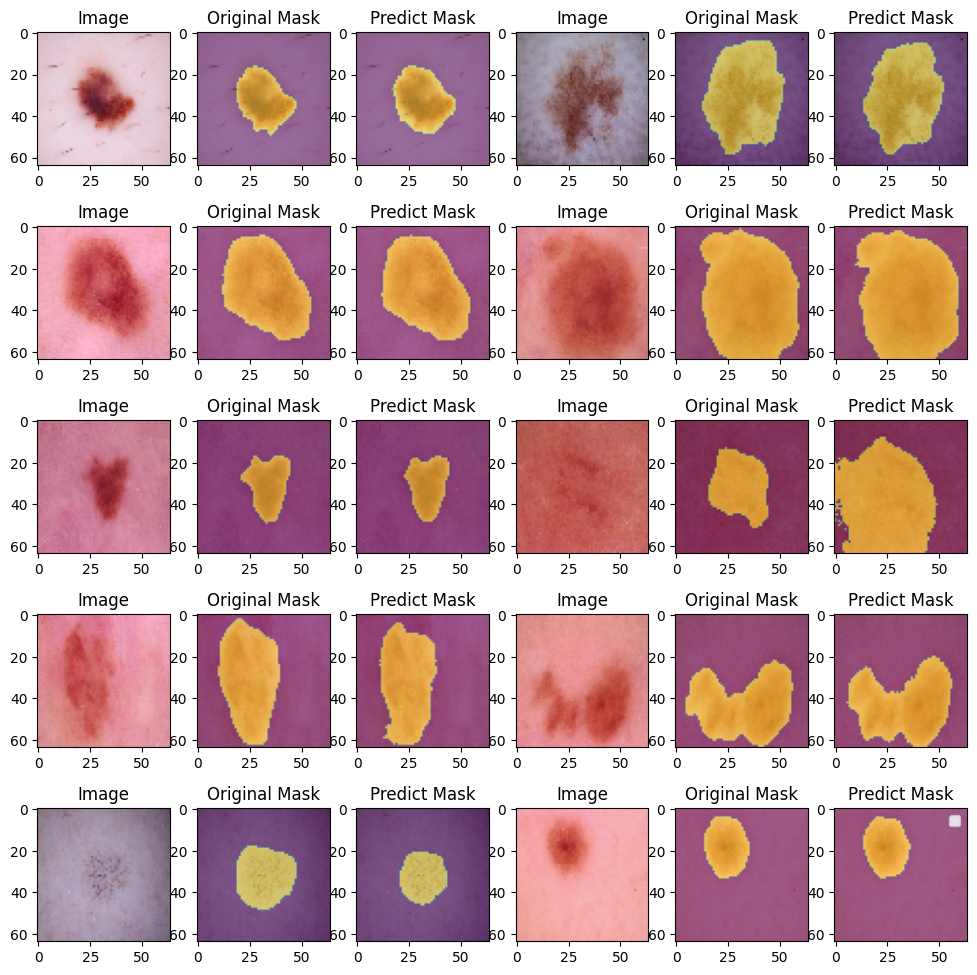

In [82]:
draw(validImages, validMasks, masks_pred, 30)